# Assignment 1 (part I): Line Fitting

## Problem 1
### Prove that affine transformations preserve parallel lines.

Solution:

Let $l_1(t)=\vec{p}+\vec{d}t$ represent a line and $\vec{d}$ is a direction vector. Applying affine transformations to $l_1$ gives:

$A(\vec{p}+\vec{d}t)+\vec{b}=(A\vec{p}+\vec{b})+(A\vec{d})t=\vec{p'}+\vec{d'}t=l_1'(t)$ where $\vec{p'}=(A\vec{p}+\vec{b})$ and $\vec{d'}=(A\vec{d})$

Let $l_2(k)=\vec{p_2}+\vec{d}k$ represent a line parallel to $l_1$ with the same direction vector $\vec{d}$. Applying the same affine transformations to $l_2$ gives:

$A(\vec{p_2}+\vec{d}k)+\vec{b}=(A\vec{p_2}+\vec{b})+(A\vec{d})k=\vec{p_2'}+\vec{d'}k=l_2'(k)$

Comparing $l_1'$ and $l_2'$, we see they have the same direction vector $\vec{d'}$. Thus, $l_1'$ and $l_2'$ are also parallel

## Problem 2 (least-squares)
### Complete implementation of function $estimate$ of class $LeastSquareLine$ below. It should update line parameters $a$ and $b$ correpsonding to line model $y=ax+b$. You can use either SVD of matrix $A$ or inverse of matrix $A^T A$, as discussed in class. NOTE: several cells below test your code.

In [177]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
from skimage.measure import ransac

In [178]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0
        
    def estimate(self, points2D):
        B = points2D[:,1]
        A = np.copy(points2D)
        A[:,1] = 1.0 

        # Vector B and matrix A are already defined. Change code below
        # get the U,W,VT
        U, W, VT = la.svd(A)
        
        # find the x of UWVTx = B -> x = VT.T@W^-1@U.T@B
        x = VT.T@((U.T@B)[:2] / W)
        self.a, self.b = x
        return True
        
    def predict(self, x): return (self.a * x) + self.b
    
    def predict_y(self, x): return (self.a * x) + self.b
            
    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])
    
    def line_par(self):
        return self.a, self.b

## Problem 3 (RANSAC for robust line fitting, single model)

#### Working code below generates a noisy cloud of points in ${\cal R}^2$ from a given line and a group of outliers.

<IPython.core.display.Javascript object>


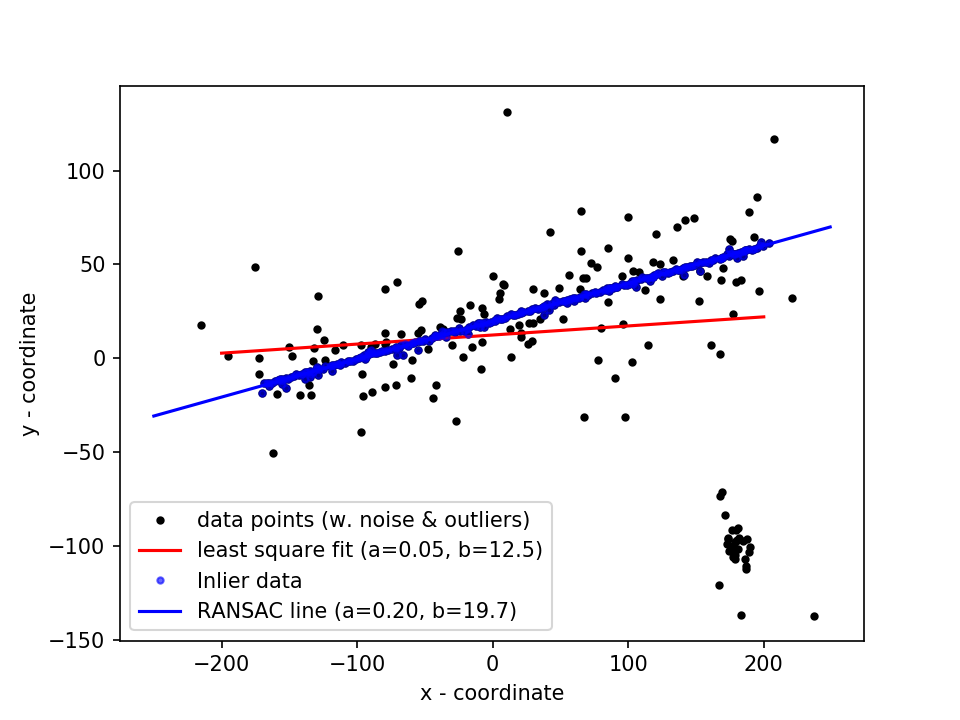

In [179]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.2, 20.0

# x-range of points [x1,x2]
x_start, x_end = -200.0, 200.0

# generate the "true" line points
x = np.arange(x_start,x_end)
y = a * x + b               
data = np.column_stack([x, y])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data += 0.5 * noise
data[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

#### Code below uses your implementation of class $LeastSquareLine$ for least-square line fitting for the data above. The estimated line is displayed in the cell above. Use this cell to test your code in Problem 2. Of course, your least-square line will be affected by the outliers.

In [180]:
LSline = LeastSquareLine() # uses class implemented in Problem 2
LSline.estimate(data)
a_ls, b_ls = LSline.line_par()

# visualizing estimated line
ends = np.array([x_start,x_end])
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

### (part a) Assume that a set of $N=100$ points in $2D$ includes $N_i=20$ inliers for one line and $N_o=80$ outliers. What is the least number of times one should sample a random pair of points from the set to get probability $p\geq 0.95$ that in at least one of the sampled pairs both points are inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution: 74 times/samples

Let assume i is the probability that the chosen points is the outlier. Thus, $1-i$ is the probability that the chosen point is inlier. Since we need two points to draw the line, $(1-i)^2$ is the probability that both points are the inliers. For a more general case, $(1-i)^K$ will be the probability that all K points are the inliers. Futhermore, $1-(1-i)^2$ is the probability of one of more points are the outliers. Rise that to C, $(1-(1-i)^2)^C$ will then be the probability that C chosen samples (the chosen two points) contains one or more points that are outliers. We negate that, $1-((1-(1-i)^2)^C)$ will then gived us the probability of C chosen samples contains at least one sample (both the two chosen point) that are inliers which is the p we want! With the above situation, $0.95=1-((1-(1-\frac{80}{100})^2)^C)$ and we can solve for C for the sample size needed which is $73.385250.....$ so rougth 74 sample needed.

### (part b) Using the knowledge of the number of inliers/outliers in the example at the beginning of Problem 3, estimate the minimum number of sampled pairs needed to get RANSAC to "succeed" (to get at least one pair of inliers) with $p\geq 0.95$. Use your formula in part (a). Show your numbers in the cell below. Then, use your estimate as a value of parameter $max\text{_}trials$  inside function $ransac$ in the code cell below and test it.  You should also change $residual\text{_}threshold$ according to the noise level for inliers in the example. NOTE: the result is displayed in the same figure at the beginning of Problem 3.

Your estimates: 2 samples needed

$0.95=1-((1-(1-\frac{30}{400})^2)^C)$ -> $C=1.5479....$

In [181]:
# robustly fit line using RANSAC algorithm
model_robust, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=4, max_trials=2)
a_rs, b_rs = model_robust.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust.predict_y(line_x)

#fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()

## Problem 4 (sequential RANSAC for robust multi-line fitting)

#### Generating noisy data with outliers

<IPython.core.display.Javascript object>


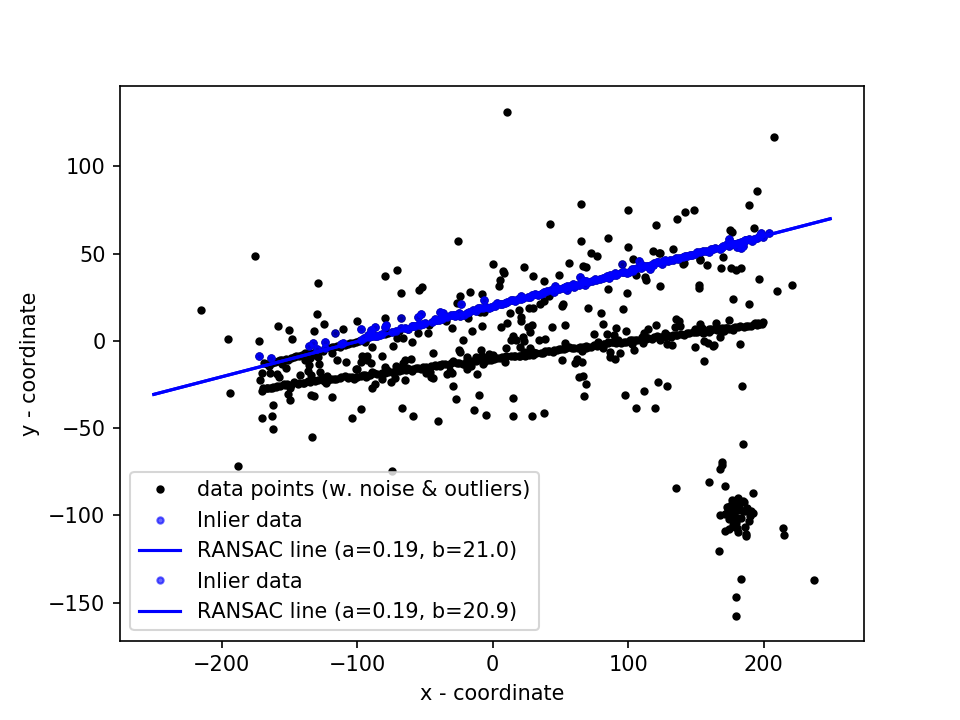

In [182]:
# parameters for "true" lines y = a*x + b
a2, b2 = 0.1, -10.0

# generate the "true" line points
y2 = a2 * x + b2
data2 = np.column_stack([x, y2])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data2[:faulty.shape[0]] = faulty   # replacing the first 30 points in data2 with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data2+= 0.5 * noise
data2[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data2[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

data = np.concatenate((data,data2)) # combining with previous data

fig2, ax2 = plt.subplots()
ax2.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax2.set_xlabel('x - coordinate')
ax2.set_ylabel('y - coordinate')
ax2.legend(loc='lower left')
plt.show()

### Write code below using sequential RANSAC to detect two lines in the data above. Your lines should be displayed in the figure above.

In [183]:
# robustly fit line using RANSAC algorithm
model_robust2, inliers2 = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=4, max_trials=2)
a_rs2, b_rs2 = model_robust2.line_par()

# generate coordinates of estimated models
line_x2 = np.arange(-250, 250)
line_y_robust2 = model_robust.predict_y(line_x2)

#fig, ax = plt.subplots()
ax2.plot(data[inliers2, 0], data[inliers2, 1], '.b', alpha=0.6, label='Inlier data')
ax2.plot(line_x2, line_y_robust2, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs2,b_rs2))
ax2.legend(loc='lower left')
plt.show()

In [184]:
# Count the number of outliers
count = 0
for i in range(inliers2.shape[0]):
    if (inliers2[i] == True):
        count = count+1

# Get rid of the inliers
data2 = np.zeros((count,2))
idx = 0
for j in range(inliers2.shape[0]):
    if (inliers2[j] == True):
        data2[idx][0] = data[j][0]
        data2[idx][1] = data[j][1]
        idx = idx+1

# robustly fit line using RANSAC algorithm again
model_robust3, inliers3 = ransac(data2, LeastSquareLine, min_samples=2, residual_threshold=4, max_trials=2)
a_rs3, b_rs3 = model_robust3.line_par()

# generate coordinates of estimated models
line_x3 = np.arange(-250, 250)
line_y_robust3 = model_robust.predict_y(line_x3)

# plot the graph
ax2.plot(data2[inliers3, 0], data2[inliers3, 1], '.b', alpha=0.6, label='Inlier data')
ax2.plot(line_x3, line_y_robust3, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs3,b_rs3))
ax2.legend(loc='lower left')
plt.show()